# Example: Convolutional Neural Network Representation of Image Patches

In [2]:
import math
import torch
import torch.nn as nn
import torchvision.models as models 
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np 
import os
import ssl
import xml.etree.ElementTree as ET
import matplotlib
from scipy.spatial import distance as dist 
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
import umap.umap_ as umap
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import dis_of_dis_transform

/home/jinkel/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### Download the pretrained CNN

In [3]:
ssl._create_default_https_context = ssl._create_unverified_context
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

# define another class so that the network can output intermediate layer
class AlexNet(torch.nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(*list(alexnet.features.children()))
        self.avgpool = alexnet.avgpool
        self.classifier = nn.Sequential(*list(alexnet.classifier.children()))

    def forward(self, x):
        results = []
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        for ii, model in enumerate(self.classifier):
            x = model(x)
            if ii == 1: # extract fc6 response (classifier (1)) 
                results.append(x)
        return x, results         
    
# define another class so that the network can output intermediate layer
class VGG16(torch.nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(*list(vgg16.features.children()))
        self.avgpool = vgg16.avgpool
        self.classifier = nn.Sequential(*list(vgg16.classifier.children()))

    def forward(self, x):
        results = []
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        for ii, model in enumerate(self.classifier):
            x = model(x)
            if ii == 0: # extract fc6 response (classifier (1)) 
                results.append(x)
        return x, results      
    
    
# feedforward CNN model 
model=AlexNet()
# model=VGG16()
# model.eval()

In [7]:
# path to the image folder
filenames  = os.listdir('/mnt/gs/home/jinkel/Desktop/disofdis_tsne/scripts/VOCdevkit/VOC2007/JPEGImages/')
input_batch = []
noise_batch = []
class_label = []
n_img = len(filenames)
for i in range(n_img):
    if filenames[i].endswith('.jpg'):
        img_id = filenames[i].strip('.jpg')
        # read the annotation files of images 
        tree = ET.parse('/mnt/gs/home/jinkel/Desktop/disofdis_tsne/scripts/VOCdevkit/VOC2007/Annotations/{}.xml'.format(img_id))
        root = tree.getroot()
        if len(root.findall('object'))==1:     # if only single object in the image 
            filename = '/mnt/gs/home/jinkel/Desktop/disofdis_tsne/scripts/VOCdevkit/VOC2007/JPEGImages/{}.jpg'.format(img_id)
            input_image = Image.open(filename)
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(227),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            input_tensor = preprocess(input_image)
            input_batch.append(input_tensor)
            noise_tensor = transforms.ToTensor()(transforms.functional.crop(input_image, 0, 0, 227, 227)) #top left corner
            noise_batch.append(noise_tensor)
            class_label.append(root[6][0].text)

input_batch = torch.stack(input_batch)
noise_batch = torch.stack(noise_batch)
total_batch = torch.cat([input_batch, noise_batch], dim=0)

# label_dict = {np.unique(class_label)[i]:i for i in range(len(np.unique(class_label)))}
n_img = len(class_label)
label_dict = {'aeroplane': 4,
 'bicycle': 2,
 'bird': 18,
 'boat': 5,
 'bottle': 10,
 'bus': 1,
 'car': 0,
 'cat': 13,
 'chair': 7,
 'cow': 15,
 'diningtable': 9,
 'dog': 14,
 'horse': 16,
 'motorbike': 3,
 'person': 19,
 'pottedplant': 11,
 'sheep': 17,
 'sofa': 8,
 'train': 6,
 'tvmonitor': 12}
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: list(label_dict.keys())[list(label_dict.values()).index(int(x))])
class_label_color = [label_dict[i] for i in class_label] 

In [8]:
# image patches only 
# tsne on the intermediate layer response 
with torch.no_grad():
    output, intermediate_img = model(input_batch)

# Visualize the image classification by pretrained AlexNet 
output = torch.nn.functional.softmax(output, dim=1).detach().numpy() # softmax
# _ = [plt.plot(output[j,:]) for j in range(500)] # classification 500 examples    
intermediate_img = intermediate_img[0].detach().numpy()

# tsne/umap on intermediate layer response 
distances = dist.squareform(dist.pdist(intermediate_img,'euclidean'))
embedding_tsne = TSNE(n_components=2, metric='euclidean', init='pca', perplexity=20).fit_transform(intermediate_img)
embedding_umap = umap.UMAP(metric='euclidean', n_neighbors=100).fit_transform(intermediate_img)

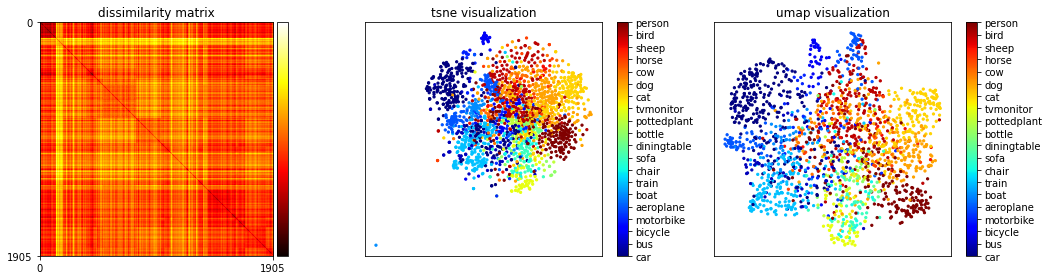

In [10]:
# visualization 
fig, axa = plt.subplots(1,3, figsize=(15,4))
distances_sorted = dist.squareform(dist.pdist(intermediate_img[np.argsort(class_label),:],'euclidean'))
q1, q3 = np.percentile(distances_sorted.flatten(),[25,75])
iqr = q3-q1
lower = q1 - (1.5*iqr)
upper = q3 + (1.5*iqr)
im1 = axa[0].imshow(distances_sorted, aspect='equal',cmap='hot'); 
axa[0].set_title('dissimilarity matrix')    
im1.set_clim(lower, upper)
plt.colorbar(im1,ax=axa[0], ticks=[0,math.floor(np.max(distances_sorted)*100)/100.0],cax=make_axes_locatable(axa[0]).append_axes("right", size="5%", pad=0.05))
axa[0].set_xticks([0, distances_sorted.shape[0]]); axa[0].set_yticks([0, distances_sorted.shape[0]])

im2 = axa[1].scatter(embedding_tsne[:n_img, 0], embedding_tsne[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im2, ax=axa[1], format=fmt,ticks=np.arange(20));
axa[1].set_xticklabels([]); axa[1].set_xticks([])
axa[1].set_yticklabels([]); axa[1].set_yticks([])
axa[1].set_title('tsne visualization')

im3 = axa[2].scatter(embedding_umap[:n_img, 0], embedding_umap[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im3, ax=axa[2], format=fmt,ticks=np.arange(20));
axa[2].set_xticklabels([]); axa[2].set_xticks([])
axa[2].set_yticklabels([]); axa[2].set_yticks([])
axa[2].set_title('umap visualization')

plt.tight_layout(); plt.show()

In [11]:
# DOD ONLY ON CLUSTER POINTS

k = 20 # size of neighborhood  
ddistances = dis_of_dis_transform(distances, n_neighbors = k)
embedding_tsne_dod = TSNE(n_components=2, metric='precomputed', perplexity=20).fit_transform(ddistances)
embedding_umap_dod = umap.UMAP(metric='precomputed', n_neighbors=100).fit_transform(ddistances)

/home/jinkel/anaconda3/envs/deep/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


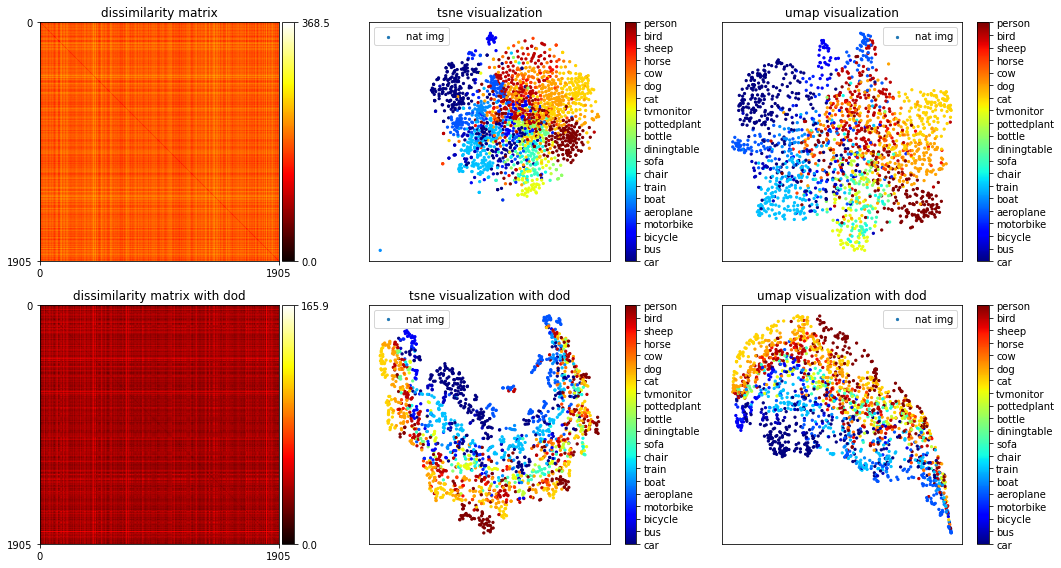

In [12]:
# Visualization 
fig, axa = plt.subplots(2,3, figsize=(15,8))

im1 = axa[0][0].imshow(distances, aspect='equal',cmap='hot'); 
axa[0][0].set_title('dissimilarity matrix')
plt.colorbar(im1,ax=axa[0][0],ticks=[0,math.floor(np.max(distances)*100)/100.0],cax=make_axes_locatable(axa[0][0]).append_axes("right", size="5%", pad=0.05))
axa[0][0].set_xticks([0, distances.shape[0]]); axa[0][0].set_yticks([0, distances.shape[0]])

im2 = axa[1][0].imshow(ddistances, aspect='equal',cmap='hot'); 
axa[1][0].set_title('dissimilarity matrix with dod')
plt.colorbar(im2,ax=axa[1][0],ticks=[0,math.floor(np.max(ddistances)*100)/100.0],cax=make_axes_locatable(axa[1][0]).append_axes("right", size="5%", pad=0.05))
axa[1][0].set_xticks([0, ddistances.shape[0]]); axa[1][0].set_yticks([0, ddistances.shape[0]])

im3 = axa[0][1].scatter(embedding_tsne[:n_img, 0], embedding_tsne[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im3, ax=axa[0][1], format=fmt,ticks=np.arange(20));
axa[0][1].set_title('tsne visualization');axa[0][1].legend(['nat img','noise'])
axa[0][1].set_xticklabels([]); axa[0][1].set_xticks([])
axa[0][1].set_yticklabels([]); axa[0][1].set_yticks([])

im4 = axa[1][1].scatter(embedding_tsne_dod[:n_img, 0], embedding_tsne_dod[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im4, ax=axa[1][1], format=fmt,ticks=np.arange(20));
axa[1][1].set_title('tsne visualization with dod');axa[1][1].legend(['nat img','noise'])
axa[1][1].set_xticklabels([]); axa[1][1].set_xticks([])
axa[1][1].set_yticklabels([]); axa[1][1].set_yticks([])

im5 = axa[0][2].scatter(embedding_umap[:n_img, 0], embedding_umap[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im5, ax=axa[0][2], format=fmt,ticks=np.arange(20));
axa[0][2].set_title('umap visualization');axa[0][2].legend(['nat img','noise'])
axa[0][2].set_xticklabels([]); axa[0][2].set_xticks([])
axa[0][2].set_yticklabels([]); axa[0][2].set_yticks([])

im6 = axa[1][2].scatter(embedding_umap_dod[:n_img, 0], embedding_umap_dod[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im6, ax=axa[1][2], format=fmt,ticks=np.arange(20));
axa[1][2].set_title('umap visualization with dod');axa[1][2].legend(['nat img','noise'])
axa[1][2].set_xticklabels([]); axa[1][2].set_xticks([])
axa[1][2].set_yticklabels([]); axa[1][2].set_yticks([])

plt.tight_layout(); plt.show()

In the absence of noise points, the application of distance-of-distance transformation introduces some distortion to the original manifold 

In [13]:
# image patches with noise patches 
# tsne on the intermediate layer response 
with torch.no_grad():
    output, intermediate = model(total_batch)

# tsne/umap on intermediate layer response 
intermediate = intermediate[0].detach().numpy()
embedding_tsne = TSNE(n_components=2, metric='euclidean', init='pca',perplexity = 20).fit_transform(intermediate)
embedding_umap = umap.UMAP(metric='euclidean', n_neighbors=100).fit_transform(intermediate)

In [14]:
# tsne/umap on dod distance matrix 
distances = dist.squareform(dist.pdist(intermediate,'euclidean'))
ddistances = dis_of_dis_transform(distances, 5)
embedding_tsne_dod = TSNE(n_components=2, metric='precomputed', perplexity = 20).fit_transform(ddistances)
embedding_umap_dod = umap.UMAP(metric='precomputed', n_neighbors=100).fit_transform(ddistances)

/home/jinkel/anaconda3/envs/deep/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


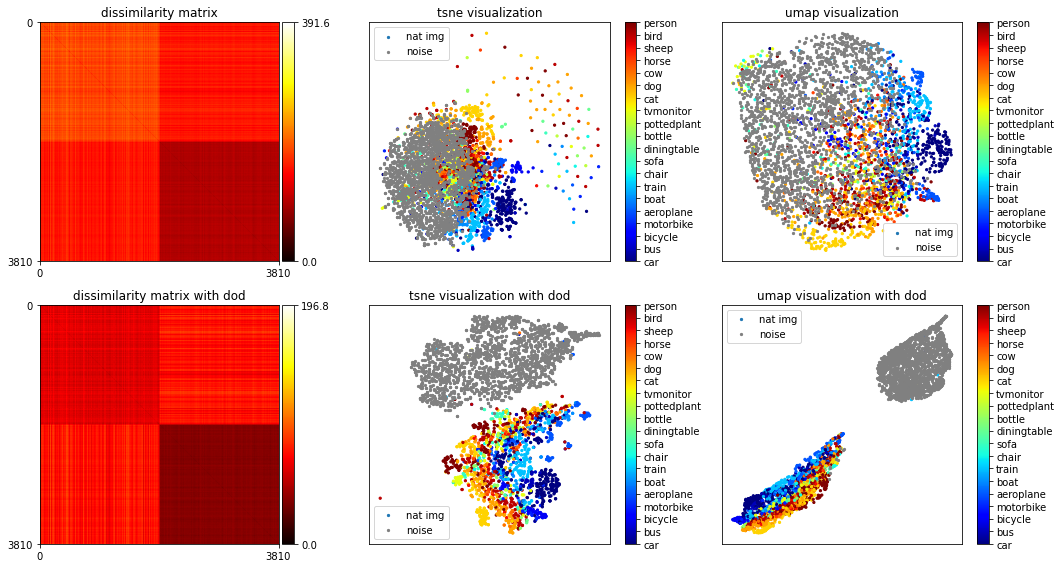

In [16]:
#%% visualization
fig, axa = plt.subplots(2,3, figsize=(15,8))

im1 = axa[0][0].imshow(distances, aspect='equal',cmap='hot'); 
axa[0][0].set_title('dissimilarity matrix')
plt.colorbar(im1,ax=axa[0][0],ticks=[0,math.floor(np.max(distances)*100)/100.0],cax=make_axes_locatable(axa[0][0]).append_axes("right", size="5%", pad=0.05))
axa[0][0].set_xticks([0, distances.shape[0]]); axa[0][0].set_yticks([0, distances.shape[0]])

im2 = axa[1][0].imshow(ddistances, aspect='equal',cmap='hot'); 
axa[1][0].set_title('dissimilarity matrix with dod')
plt.colorbar(im2,ax=axa[1][0],ticks=[0,math.floor(np.max(ddistances)*100)/100.0],cax=make_axes_locatable(axa[1][0]).append_axes("right", size="5%", pad=0.05))
axa[1][0].set_xticks([0, ddistances.shape[0]]); axa[1][0].set_yticks([0, ddistances.shape[0]])

im3 = axa[0][1].scatter(embedding_tsne[:n_img, 0], embedding_tsne[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im3, ax=axa[0][1], format=fmt,ticks=np.arange(20));
axa[0][1].scatter(embedding_tsne[n_img:, 0], embedding_tsne[n_img:, 1],c='grey',marker='o',s = 5) 
axa[0][1].set_title('tsne visualization');axa[0][1].legend(['nat img','noise'])
axa[0][1].set_xticklabels([]); axa[0][1].set_xticks([])
axa[0][1].set_yticklabels([]); axa[0][1].set_yticks([])

im4 = axa[1][1].scatter(embedding_tsne_dod[:n_img, 0], embedding_tsne_dod[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im4, ax=axa[1][1], format=fmt,ticks=np.arange(20));
axa[1][1].scatter(embedding_tsne_dod[n_img:, 0], embedding_tsne_dod[n_img:, 1],c='grey',marker='o',s = 5) 
axa[1][1].set_title('tsne visualization with dod');axa[1][1].legend(['nat img','noise'])
axa[1][1].set_xticklabels([]); axa[1][1].set_xticks([])
axa[1][1].set_yticklabels([]); axa[1][1].set_yticks([])

im5 = axa[0][2].scatter(embedding_umap[:n_img, 0], embedding_umap[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im5, ax=axa[0][2], format=fmt,ticks=np.arange(20));
axa[0][2].scatter(embedding_umap[n_img:, 0], embedding_umap[n_img:, 1],c='grey',marker='o',s = 5) 
axa[0][2].set_title('umap visualization');axa[0][2].legend(['nat img','noise'])
axa[0][2].set_xticklabels([]); axa[0][2].set_xticks([])
axa[0][2].set_yticklabels([]); axa[0][2].set_yticks([])

im6 = axa[1][2].scatter(embedding_umap_dod[:n_img, 0], embedding_umap_dod[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im6, ax=axa[1][2], format=fmt,ticks=np.arange(20));
axa[1][2].scatter(embedding_umap_dod[n_img:, 0], embedding_umap_dod[n_img:, 1],c='grey',marker='o',s = 5) 
axa[1][2].set_title('umap visualization with dod');axa[1][2].legend(['nat img','noise'])
axa[1][2].set_xticklabels([]); axa[1][2].set_xticks([])
axa[1][2].set_yticklabels([]); axa[1][2].set_yticks([])

plt.tight_layout(); plt.show()

With distance-of-distance transformation, the noise cloud that was masking the clustering is now separated from the object manifold. 

In [18]:
#%% REVIEW: DOD COMPARED WITH PCA PREP  

# pca preprocessing 
pca = PCA(n_components=min(intermediate.shape))
intermediate_pca = pca.fit_transform(intermediate)
# plt.plot(pca.explained_variance_ratio_)
n_pc = 5
intermediate_pca = intermediate_pca[:,:5]
distances_PCA = dist.squareform(dist.pdist(intermediate_pca[:,:5],'euclidean'))
embedding_tsne_PCA = TSNE(n_components=2, metric='euclidean', init='pca', perplexity= 20).fit_transform(intermediate_pca)
embedding_umap_PCA = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=100).fit_transform(intermediate_pca)

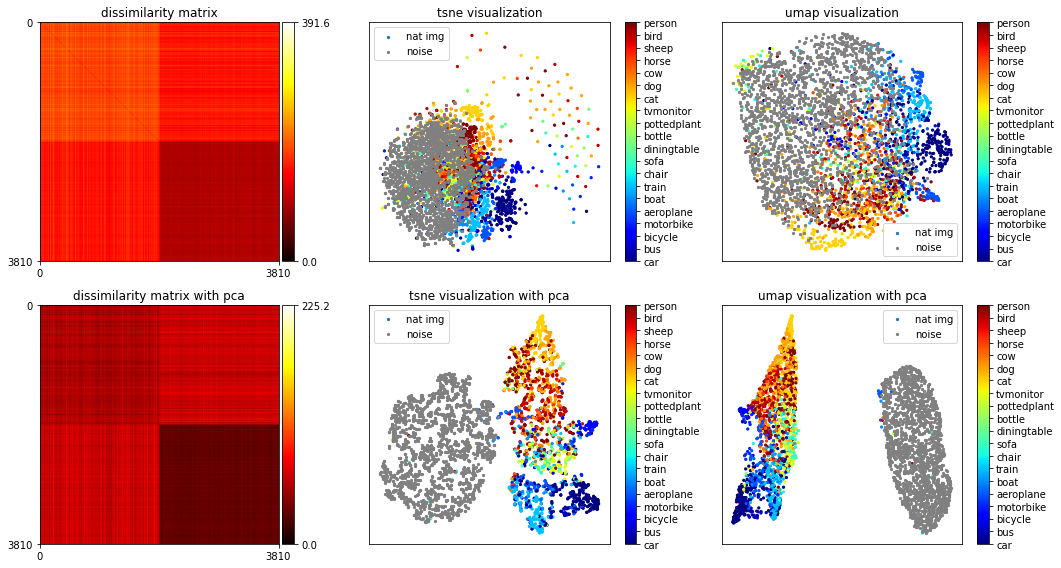

In [19]:
# visualization 
fig, axa = plt.subplots(2,3, figsize=(15,8))
im1 = axa[0][0].imshow(distances, aspect='equal',cmap='hot'); 
axa[0][0].set_title('dissimilarity matrix')
plt.colorbar(im1,ax=axa[0][0],ticks=[0,math.floor(np.max(distances)*100)/100.0],cax=make_axes_locatable(axa[0][0]).append_axes("right", size="5%", pad=0.05))
axa[0][0].set_xticks([0, distances.shape[0]]); axa[0][0].set_yticks([0, distances.shape[0]])

im2 = axa[1][0].imshow(distances_PCA, aspect='equal',cmap='hot'); 
axa[1][0].set_title('dissimilarity matrix with pca')
plt.colorbar(im2,ax=axa[1][0],ticks=[0,math.floor(np.max(distances_PCA)*100)/100.0],cax=make_axes_locatable(axa[1][0]).append_axes("right", size="5%", pad=0.05))
axa[1][0].set_xticks([0, distances_PCA.shape[0]]); axa[1][0].set_yticks([0, distances_PCA.shape[0]])

im3 = axa[0][1].scatter(embedding_tsne[:n_img, 0], embedding_tsne[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im3, ax=axa[0][1], format=fmt,ticks=np.arange(20));
axa[0][1].scatter(embedding_tsne[n_img:, 0], embedding_tsne[n_img:, 1],c='grey',marker='o',s = 5) 
axa[0][1].set_title('tsne visualization');axa[0][1].legend(['nat img','noise'])
axa[0][1].set_xticklabels([]); axa[0][1].set_xticks([])
axa[0][1].set_yticklabels([]); axa[0][1].set_yticks([])

im4 = axa[1][1].scatter(embedding_tsne_PCA[:n_img, 0], embedding_tsne_PCA[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im4, ax=axa[1][1], format=fmt,ticks=np.arange(20));
axa[1][1].scatter(embedding_tsne_PCA[n_img:, 0], embedding_tsne_PCA[n_img:, 1],c='grey',marker='o',s = 5) 
axa[1][1].set_title('tsne visualization with pca');axa[1][1].legend(['nat img','noise'])
axa[1][1].set_xticklabels([]); axa[1][1].set_xticks([])
axa[1][1].set_yticklabels([]); axa[1][1].set_yticks([])

im5 = axa[0][2].scatter(embedding_umap[:n_img, 0], embedding_umap[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im5, ax=axa[0][2], format=fmt,ticks=np.arange(20));
axa[0][2].scatter(embedding_umap[n_img:, 0], embedding_umap[n_img:, 1],c='grey',marker='o',s = 5) 
axa[0][2].set_title('umap visualization');axa[0][2].legend(['nat img','noise'])
axa[0][2].set_xticklabels([]); axa[0][2].set_xticks([])
axa[0][2].set_yticklabels([]); axa[0][2].set_yticks([])

im6 = axa[1][2].scatter(embedding_umap_PCA[:n_img, 0], embedding_umap_PCA[:n_img, 1],c=class_label_color,cmap='jet',marker='o',s = 5) 
plt.colorbar(im6, ax=axa[1][2], format=fmt,ticks=np.arange(20));
axa[1][2].scatter(embedding_umap_PCA[n_img:, 0], embedding_umap_PCA[n_img:, 1],c='grey',marker='o',s = 5) 
axa[1][2].set_title('umap visualization with pca');axa[1][2].legend(['nat img','noise'])
axa[1][2].set_xticklabels([]); axa[1][2].set_xticks([])
axa[1][2].set_yticklabels([]); axa[1][2].set_yticks([])

plt.tight_layout(); plt.show()

Other commonly used techniques including PCA preprocessing and PCA initialization cannot achieve the separation of noise points as well as distance-of-distance transformation.